<a href="https://colab.research.google.com/github/adil-1522/TRANSFORMER_pytorch/blob/main/Multi_attention_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [27]:
sequence_length=4
batch_size=1
input_dim = 512
d_model = 512
x=torch.randn((batch_size,sequence_length,d_model))

In [28]:
x.size()


torch.Size([1, 4, 512])

In [29]:
qkv_layer = nn.Linear(input_dim,3*input_dim)

In [30]:
qkv=qkv_layer(x)

In [31]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

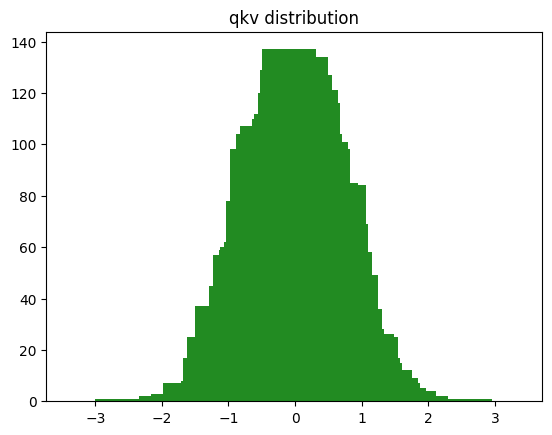

In [32]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [33]:
num_heads=8
head_dim = d_model//num_heads
qkv=qkv.reshape(batch_size,sequence_length,num_heads,3*head_dim)

In [34]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [35]:
qkv=qkv.permute(0,2,1,3)

In [36]:
qkv.shape

torch.Size([1, 8, 4, 192])

In [37]:
q,k,v=qkv.chunk(3,dim=-1)
q.shape,k.shape,v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

Self Attention for multiple Heads
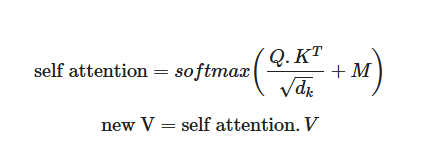


In [40]:
d_k=q.size()[-1]
scaled = torch.matmul(q,k.transpose(-1,-2))/math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [41]:
k.T.shape

torch.Size([64, 4, 8, 1])

In [42]:
y = torch.randn(2, 3)
torch.transpose(y, 0, 1)

tensor([[-0.0260, -0.2157],
        [ 1.3785,  0.5202],
        [-0.8953,  0.1278]])

In [43]:
torch.transpose(y, 1, 0)

tensor([[-0.0260, -0.2157],
        [ 1.3785,  0.5202],
        [-0.8953,  0.1278]])

In [44]:
k.transpose(-1, -2) == k.transpose(-2, -1)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [45]:
k.transpose(-1, -2).shape

torch.Size([1, 8, 64, 4])

In [48]:
mask = torch.full(scaled.size(),float('-inf'))
mask = torch.triu(mask,diagonal=1)
mask[0][1]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [49]:
(scaled+mask)[0][0]

tensor([[ 0.3264,    -inf,    -inf,    -inf],
        [ 0.3808,  0.1268,    -inf,    -inf],
        [-0.6007,  0.1025, -0.6060,    -inf],
        [ 0.0457, -0.6009,  0.4779, -0.4731]], grad_fn=<SelectBackward0>)

In [50]:
scaled+=mask

In [51]:
np.exp(0.5596) / (np.exp(0.5596) + np.exp(0.0404))

np.float64(0.6269606805367254)

In [52]:
attention = F.softmax(scaled,dim=-1)


In [53]:
attention.shape

torch.Size([1, 8, 4, 4])

In [54]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5632, 0.4368, 0.0000, 0.0000],
        [0.2491, 0.5032, 0.2477, 0.0000],
        [0.2732, 0.1431, 0.4210, 0.1626]], grad_fn=<SelectBackward0>)

In [55]:
values=torch.matmul(attention,v)
values.shape

torch.Size([1, 8, 4, 64])

Function

In [56]:
import math

def scaled_dot_product(q,k,v,mask=None):
  d_k=q.size()[-1]
  scaled = torch.matmul(q,k.transpose(-1,-2))/math.sqrt(d_k)
  if mask is not None:
    scaled+=mask
  attention=F.softmax(scaled,dim=-1)
  values=torch.matmul(attention,v)
  return values,attention

In [57]:
values,attention=scaled_dot_product(q,k,v,mask)


In [58]:
attention.shape

torch.Size([1, 8, 4, 4])

In [59]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5632, 0.4368, 0.0000, 0.0000],
        [0.2491, 0.5032, 0.2477, 0.0000],
        [0.2732, 0.1431, 0.4210, 0.1626]], grad_fn=<SelectBackward0>)

In [60]:
values.size()

torch.Size([1, 8, 4, 64])

In [63]:
values=values.reshape(batch_size,sequence_length,num_heads*head_dim)
values.size()

torch.Size([1, 4, 512])

In [64]:
linear_layer = nn.Linear(d_model, d_model)

In [65]:
out = linear_layer(values)

In [66]:
out.shape

torch.Size([1, 4, 512])

In [67]:
out

tensor([[[-0.1245,  0.5532, -0.0559,  ..., -0.2663, -0.2322,  0.0343],
         [-0.0996, -0.3708, -0.0231,  ...,  0.2806, -0.1436,  0.0516],
         [ 0.1977,  0.0681,  0.2488,  ..., -0.1401, -0.2131, -0.0197],
         [ 0.3080,  0.0058, -0.0412,  ..., -0.0909,  0.1031, -0.3433]]],
       grad_fn=<ViewBackward0>)

In [80]:
import math
import torch
import torch.nn as nn

def dot_scaled_product(q,k,v,mask=None):
  d_k =q.size()
  scaled = torch.matmul(q,k.transpose(-1,-2))/math.sqrt(d_k)
  if mask is not None:
    scaled+=mask
  attention = F.softmax(scaled,dim=-1)
  values = torch.matmul(attention,v)
  return values,attention

class MultiheadAttention(nn.Module):

  def __init__(self,input_dim,d_model,num_heads):
    super().__init__()
    self.input_dim=input_dim
    self.d_model=d_model
    self.num_heads=num_heads
    self.head_dim = d_model//num_heads
    self.qkv_layer = nn.Linear(input_dim,3*d_model)
    self.linear_layer=nn.Linear(d_model,d_model)

  def forward(self,x,mask=None):
    batch_size,sequence_length,input_dim=x.size()
    print(f"x.size(): {x.size()}")
    qkv=self.qkv_layer(x)
    print(f"qkv.size(): {qkv.size()}")
    qkv=qkv.reshape(batch_size,sequence_length,self.num_heads,3*self.head_dim)
    print(f"qkv.size():{qkv.size()}")
    qkv = qkv.permute(0,2,1,3)
    print(f"qkv.size(): {qkv.size()}")
    q,k,v = qkv.chunk(3,dim=-1)
    print(f"q.size():{q.size()},k.size():{k.size()},v.size():{v.size()}, ")
    values,attention=scaled_dot_product(q,k,v,mask)
    print(f"values.size():{values.size()},attention.size():{attention.size()}")
    values=values.reshape(batch_size,sequence_length,self.num_heads*self.head_dim)
    print(f"values.size():{values.size()}")
    out=self.linear_layer(values)
    print(f"out.size():{out.size()}")
    return out


Input


In [81]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size():torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q.size():torch.Size([30, 8, 5, 64]),k.size():torch.Size([30, 8, 5, 64]),v.size():torch.Size([30, 8, 5, 64]), 
values.size():torch.Size([30, 8, 5, 64]),attention.size():torch.Size([30, 8, 5, 5])
values.size():torch.Size([30, 5, 512])
out.size():torch.Size([30, 5, 512])
